100%|██████████| 2948/2948 [00:06<00:00, 465.80it/s]


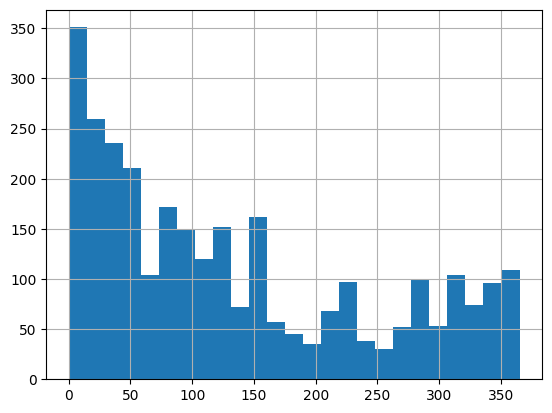

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, ClassificationMandrillImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

n_classes = 12
class_step = 365 / n_classes
name = f"exp_classif_{n_classes}"

class_dataset = ClassificationMandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, n_classes=n_classes, days_step=class_step)
reg_dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm
import numpy as np

from mandrill.models import RegressionModel, VGGFace, FeatureClassificationModel
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
classif_learning_rate = learning_rate
batch_size = 32
num_epochs = 500
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(reg_dataset, train_ratio, batch_size, augment=False)
class_train_loader, class_val_loader, class_train_dataset, class_val_dataset = split_dataset(class_dataset, train_ratio, batch_size, augment=False)

# Model
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, n_lin=6, lin_start=2048)
classif_model = RegressionModel(backbone, input_dim=backbone.output_dim, output_dim=n_classes, sigmoid=False, n_lin=6, lin_start=2048)

# Loss function
criterion = nn.MSELoss()
val_criterion = nn.L1Loss()
classif_criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
classif_optimizer = optim.Adam(classif_model.parameters(), lr=classif_learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)
classif_model = classif_model.to(device)

def train_step(loader, index, optimizer, model, criterion, device):
    images, labels = next(iter(loader))
    if isinstance(images, list):
        for i in range(len(images)):
            images[i] = images[i].to(device)
    else:
        images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    size = 0
    if isinstance(images, list):
        size = images[0].size(0)
    else:
        size = images.size(0)

    return loss.item() * size

#######
train = False
#######

name = "exp_classif_reg"
    
if train:
    # Training loop
    best_val = np.inf
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        class_train_loss = 0.0
        steps = len(train_loader)

        for i in tqdm(range(steps)):
            train_loss += train_step(train_loader, i, optimizer, model, criterion, device)
            class_train_loss += train_step(class_train_loader, i, classif_optimizer, classif_model, classif_criterion, device)

        train_loss /= len(train_dataset)
        class_train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)

        if val_loss < best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(model, "best_reg", exp_name=name)
            save(classif_model, "best_classif", exp_name=name)
        else:
            print(f"Val loss did not improved from {best_val:.4f}")

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.5f} - "
              f"Train Dual loss: {class_train_loss:.5f} - "
              f"Val MAE: {(val_loss*max_days):.5f}")

Using device: cuda


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

name = "exp_classif_reg"
model = load(model, "best_reg", exp_name=name)
model.eval()

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 0

y_true = []
y_pred = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    pred = outputs.squeeze().detach().cpu().numpy() * 365
    target = targets.squeeze().cpu().numpy() * 365
    
    y_true.append(target)
    y_pred.append(pred)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", pred)
    print("Actual Values:", target)
    print("Prediction Error: ", pred - target)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {pred}, Actual: {target}")
    plt.show()

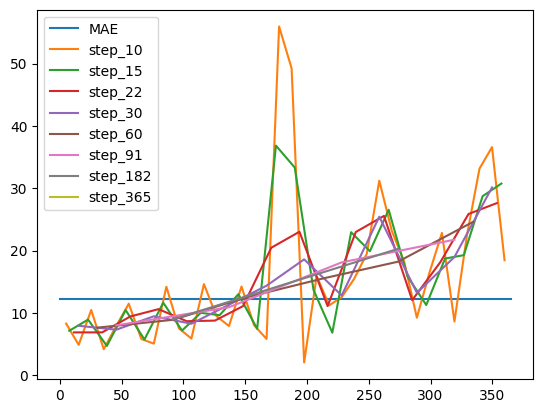

/home/rkarpinski/.venvs/vtf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rkarpinski/.venvs/vtf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4322
Precision: 0.3705
Recall: 0.3685
F1-score: 0.3273


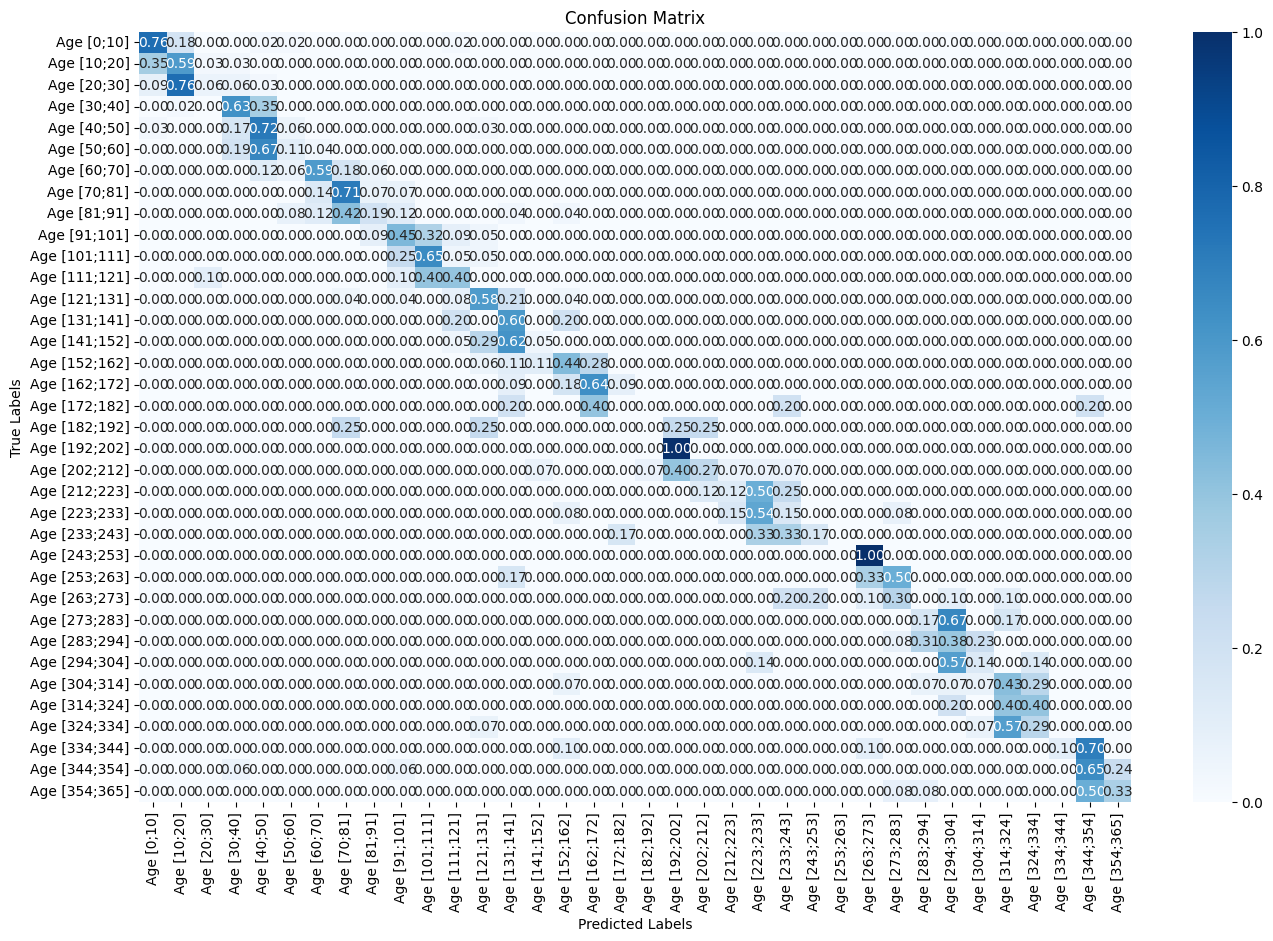

Accuracy: 0.5898
Precision: 0.5179
Recall: 0.4924
F1-score: 0.4865


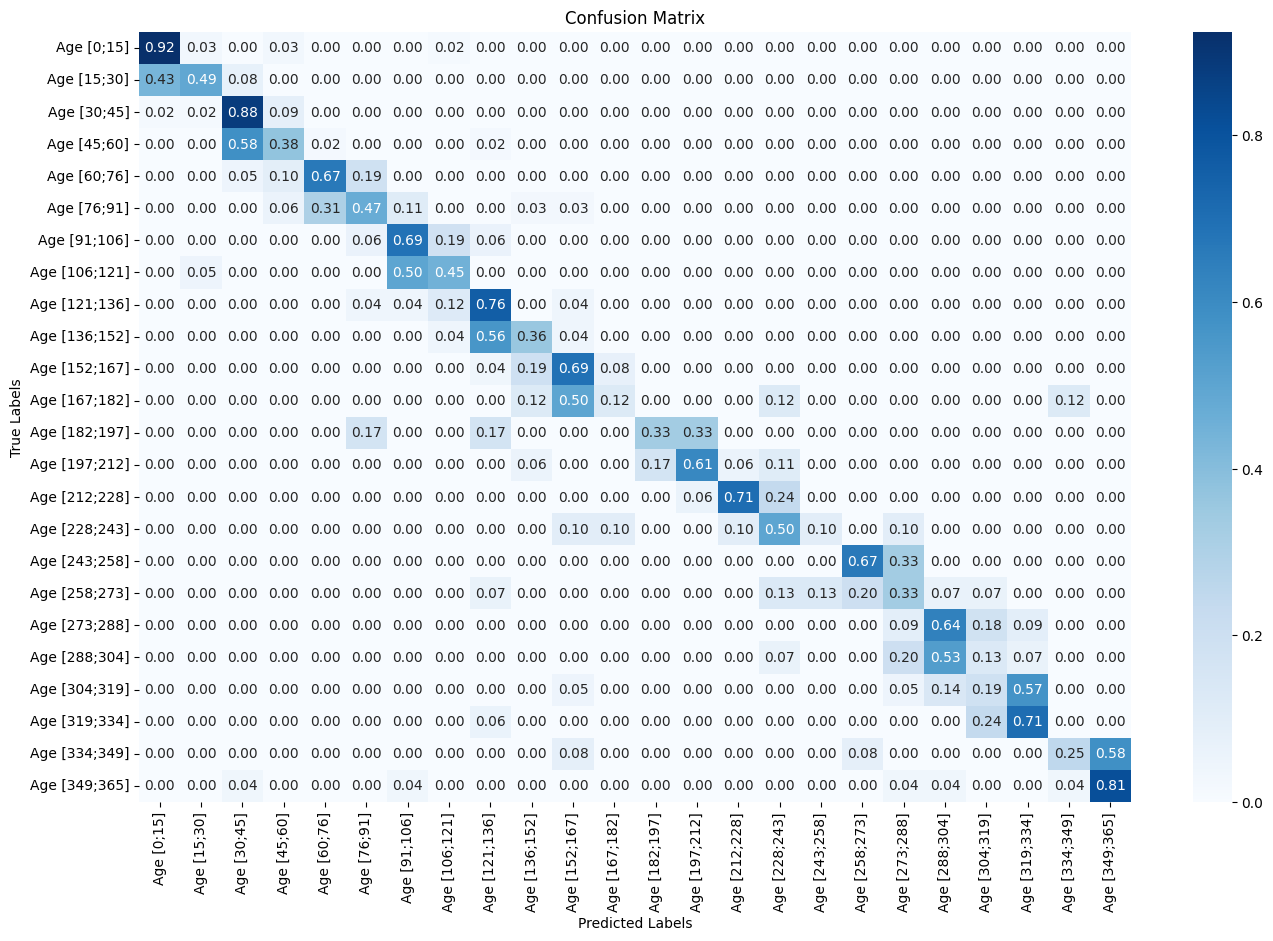

Accuracy: 0.6661
Precision: 0.6391
Recall: 0.6322
F1-score: 0.6147


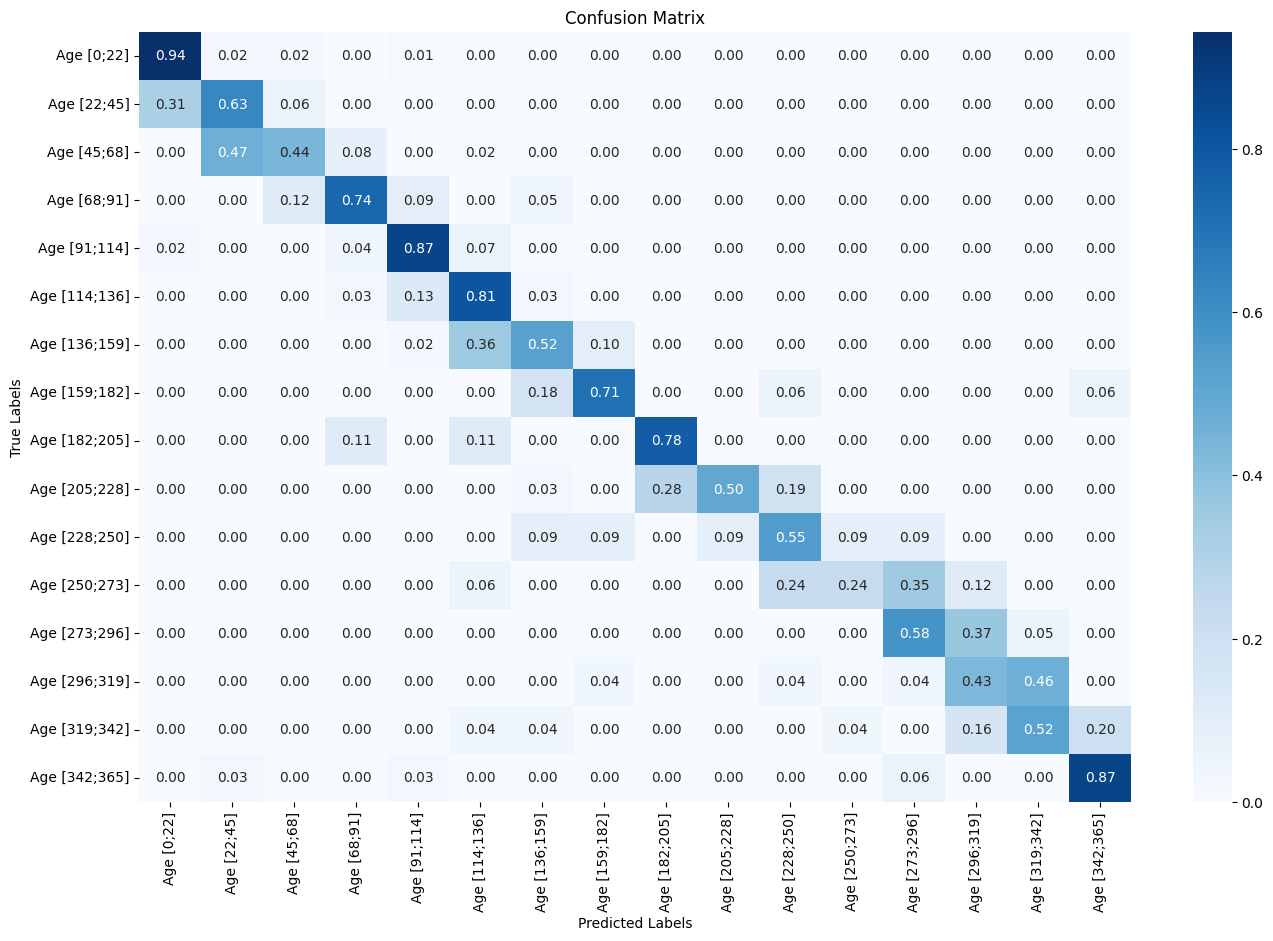

Accuracy: 0.8559
Precision: 0.8291
Recall: 0.7969
F1-score: 0.8045


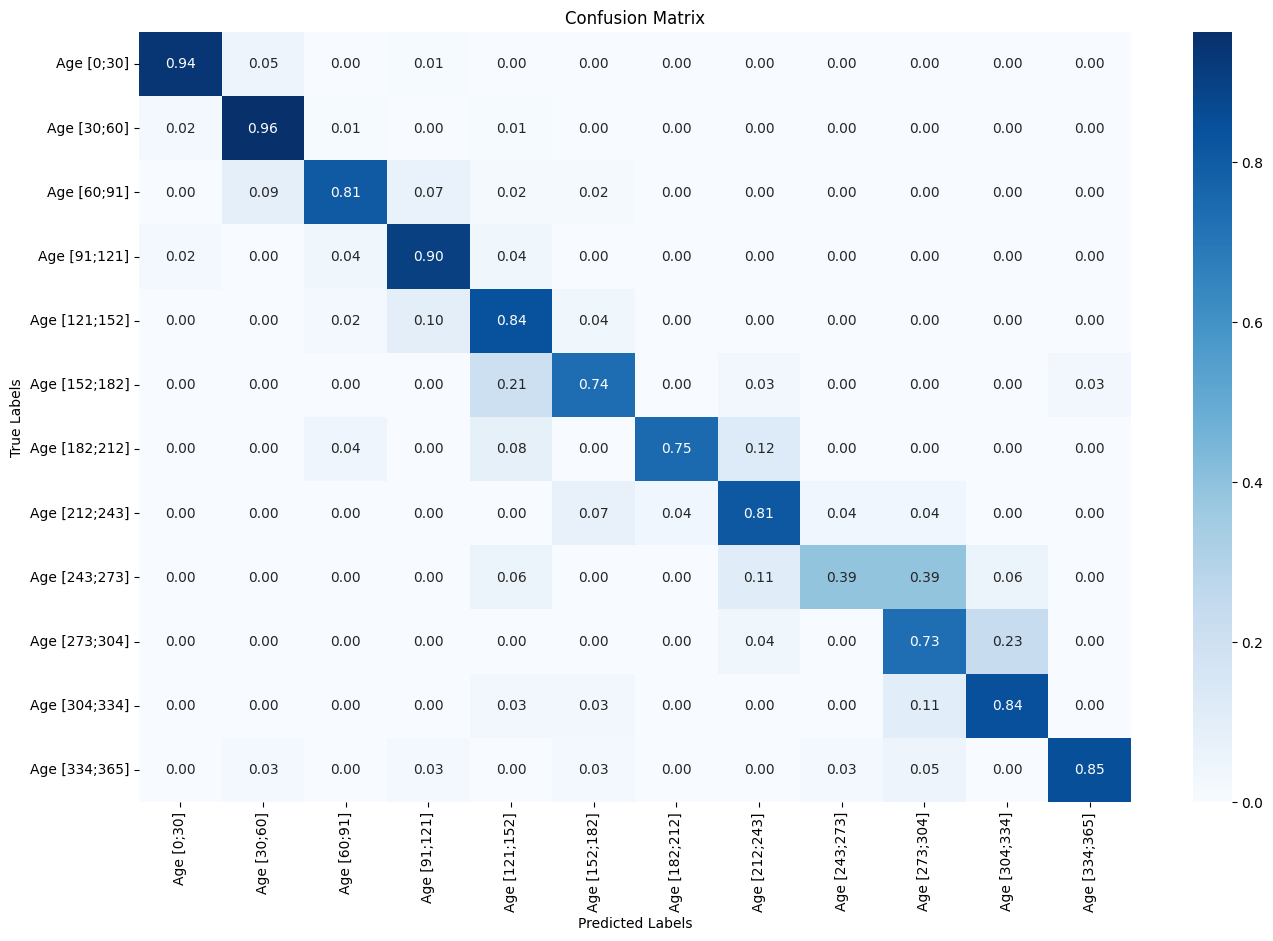

Accuracy: 0.9136
Precision: 0.8874
Recall: 0.8761
F1-score: 0.8813


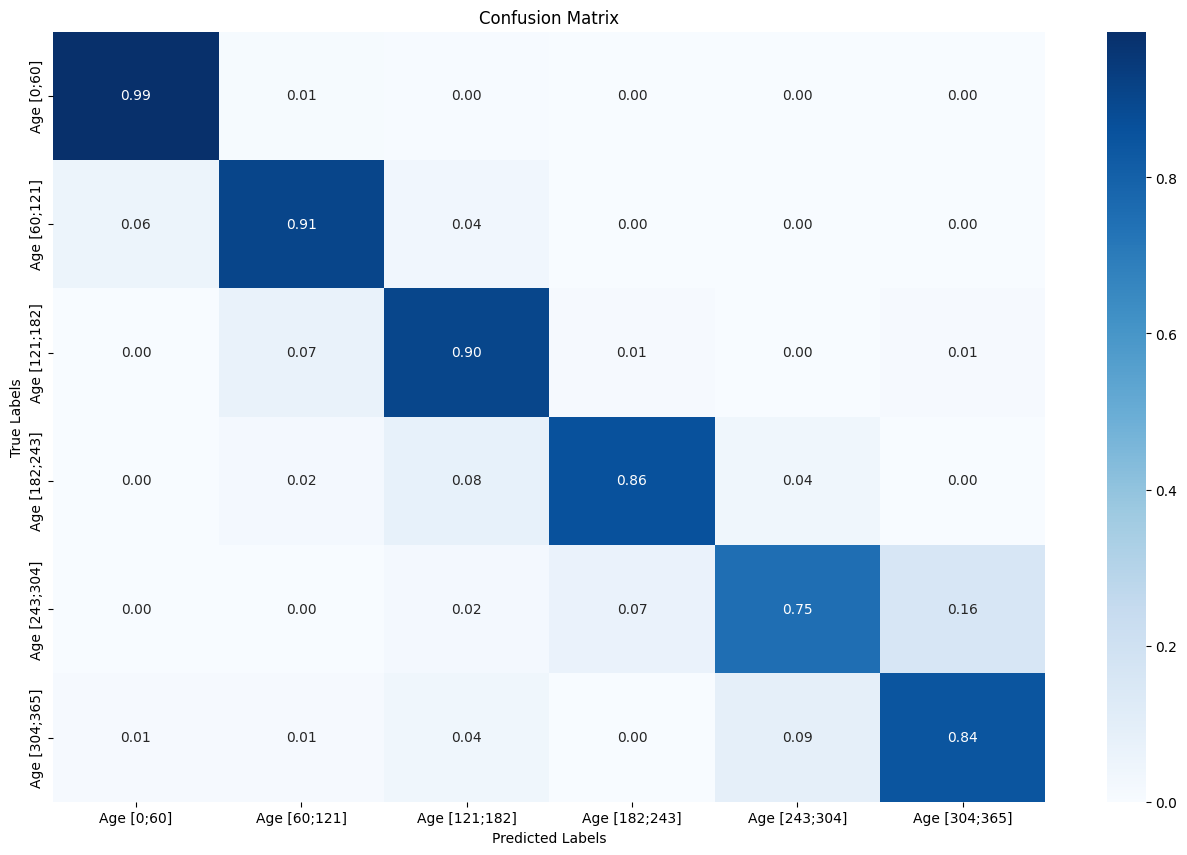

Accuracy: 0.9390
Precision: 0.9290
Recall: 0.9105
F1-score: 0.9174


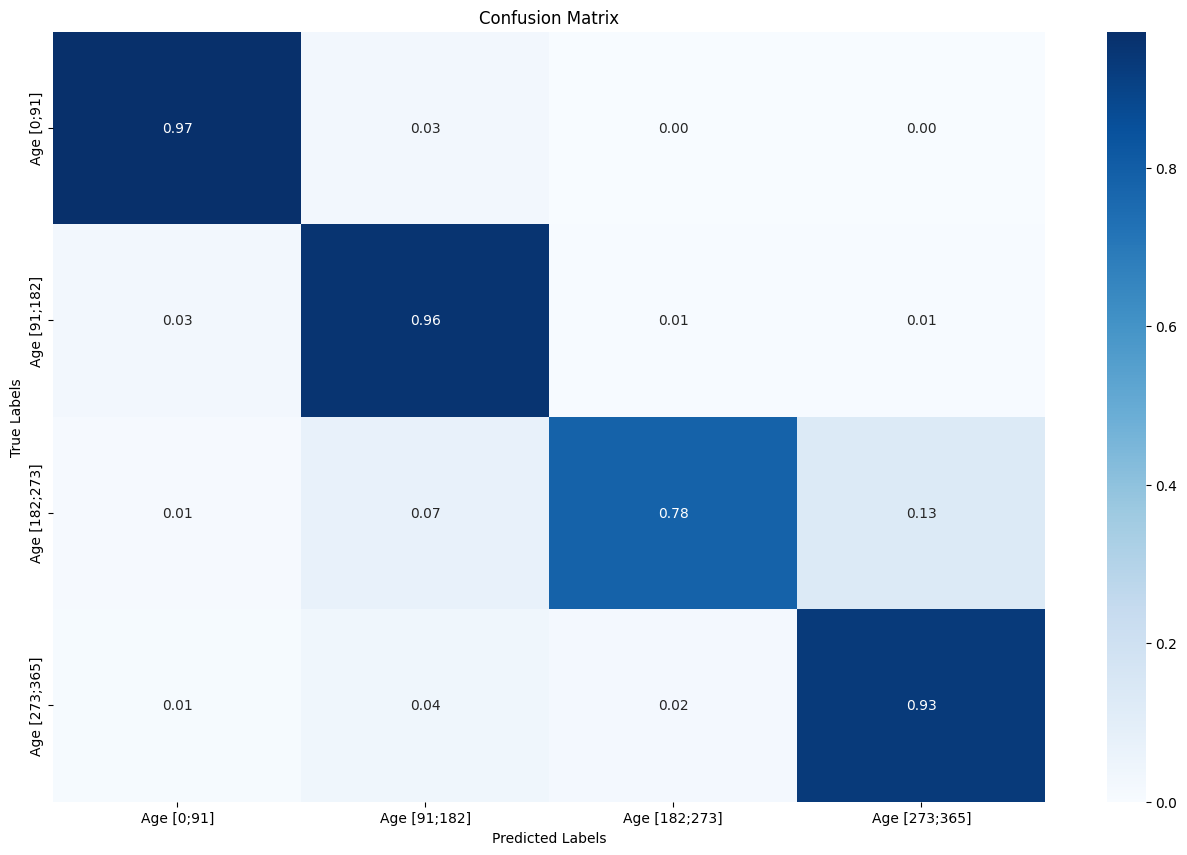

Accuracy: 0.9780
Precision: 0.9810
Recall: 0.9656
F1-score: 0.9729


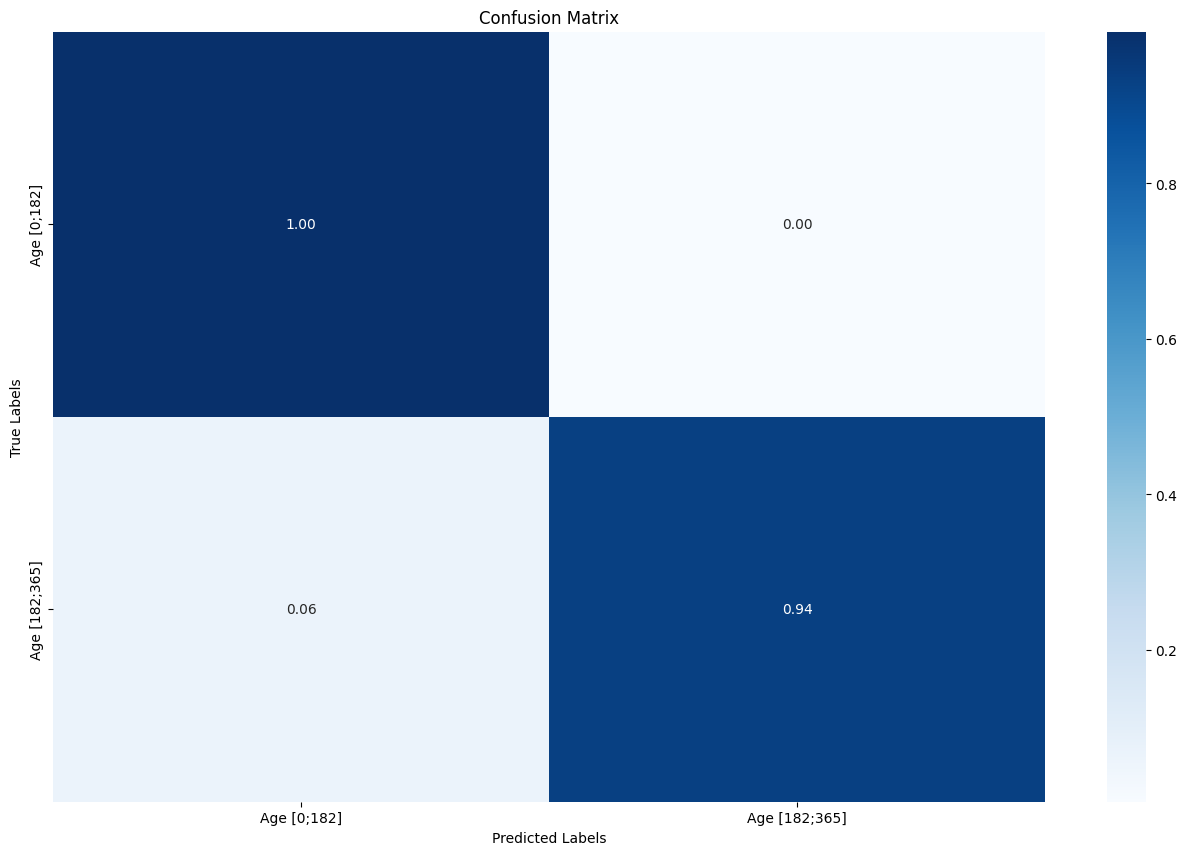

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


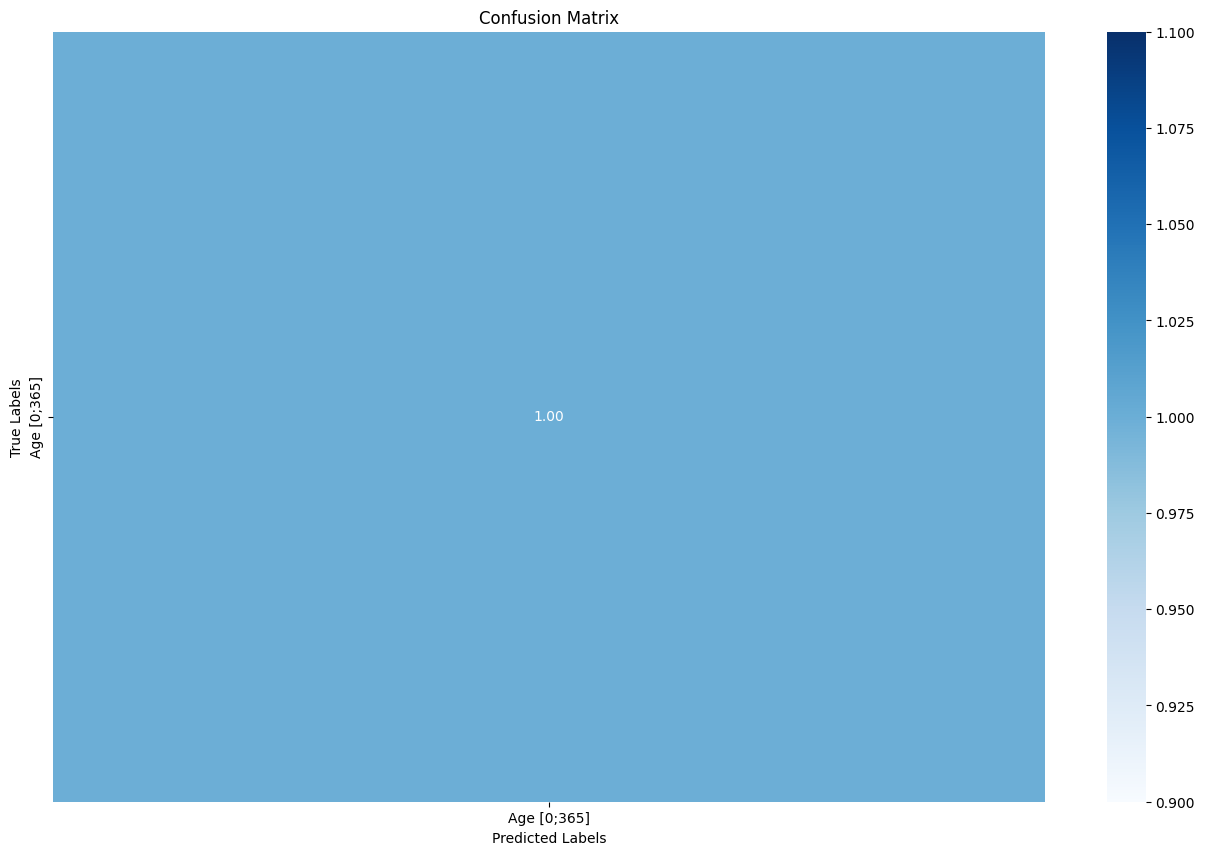

{'vgg_face_rank_regression': {'vgg_face_rank_regression_regression': {'vgg_face_rank_regression_regression_mae': 12.26779603208731,
   'vgg_face_rank_regression_regression_mae_steps': {10.13888888888889: [(5.069444444444445,
      8.299630693086952),
     (15.208333333333334, 4.887796803651487),
     (25.34722222222222, 10.480527726604658),
     (35.486111111111114, 4.188441282874623),
     (45.625, 7.926762586446582),
     (55.763888888888886, 11.4935476484674),
     (65.90277777777779, 5.827715868020759),
     (76.04166666666667, 5.08406047310148),
     (86.18055555555556, 14.215005659140074),
     (96.31944444444444, 7.553882744501937),
     (106.45833333333334, 5.893543899059296),
     (116.59722222222223, 14.635071758180857),
     (126.73611111111111, 9.494506797442833),
     (136.875, 7.914652347564697),
     (147.0138888888889, 14.240119939758664),
     (157.15277777777777, 8.04931961827808),
     (167.29166666666669, 5.834031985564665),
     (177.43055555555554, 55.952772319316

In [4]:
from mandrill.evaluations import standard_regression_evaluation

standard_regression_evaluation(np.array(y_true), np.array(y_pred), "vgg_face_rank_regression", 0, max_days)